## Using `contaminante` on *TESS* data

In [2]:
%%javascript
IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);

<IPython.core.display.Javascript object>

In [3]:
import contaminante as ct
import lightkurve as lk
import numpy as np

#### NOTE: the 1st dip in sector 48, ~BTJD 2610.5, is maked out below to see how it affects the centroid shift derived by `contaminate`.


In [4]:
# from s0048-s0048:TCE1
# https://exo.mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2022028101454-s0048-s0048-0000000018016577-01-00580_dvs.pdf
tic, sector = 18016577, [22, 48]
period=19.769411
t0=2610.5497,
duration=9.2324 / 24


In [5]:
download_dir="data"  # where to store the TPFs

# one-time config for query cache if supported in the lightkurve used
if hasattr(lk.search, "sr_cache"): 
    lk.search.sr_cache.cache_dir = download_dir

tpfs_all = lk.search_targetpixelfile(f"TIC {tic}", sector=sector).download_all(download_dir=download_dir)
print("TIC sector cadence(min), num. cadence")
for t in tpfs_all:
    print(f"TIC {t.targetid}", t.sector, f"{(np.median(np.diff(t.time.value)) * 24 * 60):.0f}", len(t))

TIC sector cadence(min), num. cadence
TIC 18016577 22 2 18619
TIC 18016577 22 30 1237
TIC 18016577 48 2 18989


In [6]:
# filter out unhelpful tpfs (sector 22 has both 30-minute and 2-minute TPFs)
tpfs = tpfs_all[0, 2]
tpfs_um = tpfs  # a copy of tpfs without additional masking 

print("TIC sector cadence(min), num. cadence")
for t in tpfs:
    print(f"TIC {t.targetid}", t.sector, f"{(np.median(np.diff(t.time.value)) * 24 * 60):.0f}", len(t))

TIC sector cadence(min), num. cadence
TIC 18016577 22 2 18619
TIC 18016577 48 2 18989


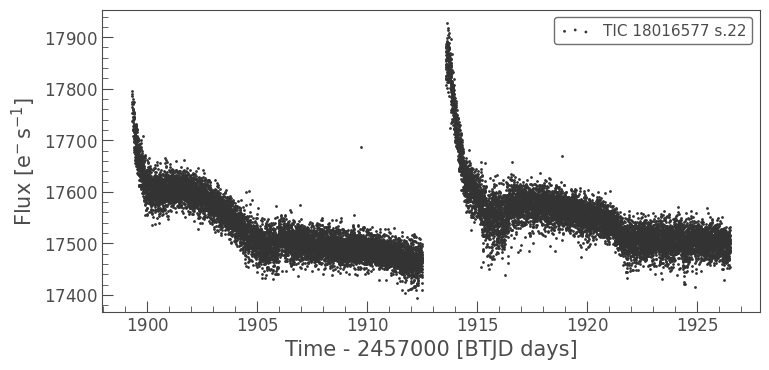

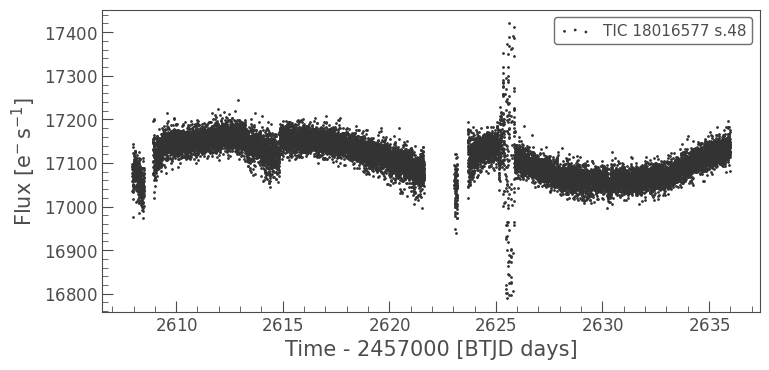

In [7]:
# Rough LCs as a reminder of what we are working with
axs = [t.to_lightcurve().remove_outliers(sigma=7).scatter(label=f"TIC {t.targetid} s.{t.sector}") for t in tpfs];

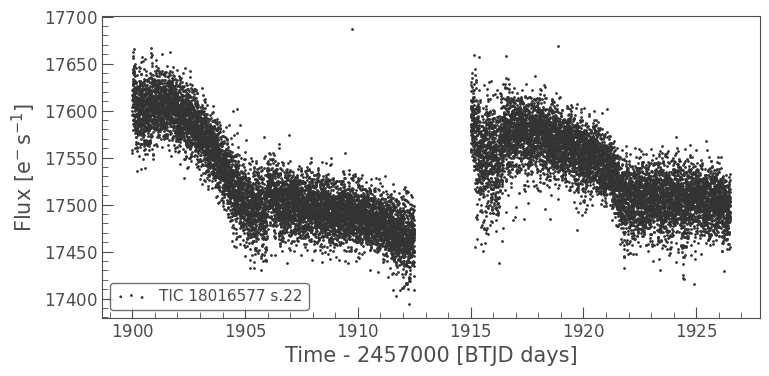

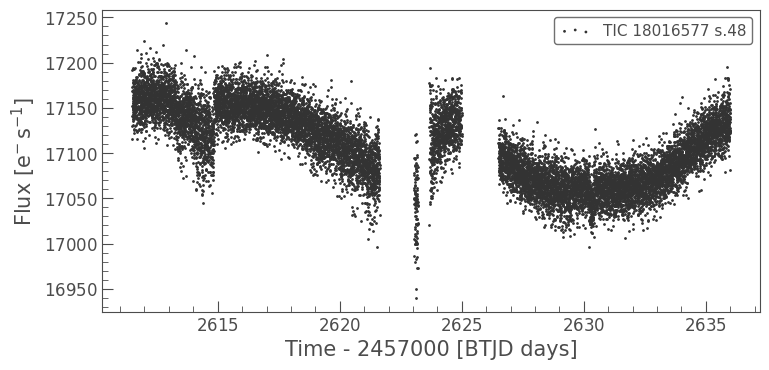

In [13]:
# some anomaly around BTJD 2625.0 - 2626.5 in sector 48
# I also mask out the first TCE dip around BTJD 2610.5, to see if the centroid shift derived by contaminate
# is due to that dip.
# for sector 22, the lightcurve at the begnning of each cycle alos seems high (probably scattered light)
# they are not tied to the dip in question so I mask it out
# to avoid skewing the result
tpfs = lk.TargetPixelFileCollection([
    tpfs_um[0][( (1900 < tpfs_um[0].time.value) & (tpfs_um[0].time.value < 1913) ) | (1915 < tpfs_um[0].time.value )],
    tpfs_um[1][( (2611.5 < tpfs_um[1].time.value) & (tpfs_um[1].time.value < 2625) ) | (2626.5 < tpfs_um[1].time.value )],
])

axs = [t.to_lightcurve().remove_outliers(sigma=7).scatter(label=f"TIC {t.targetid} s.{t.sector}") for t in tpfs];

Modeling TPFs:   0%|                                                         | 0/2 [00:00<?, ?it/s]C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:256: RuntimeWarning: invalid value encountered in multiply
  transit_pixels_err = np.zeros(tpf.flux.shape[1:]) * np.inf
C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:257: RuntimeWarning: invalid value encountered in multiply
  chi_ratio = np.zeros(tpf.flux.shape[1:]) * np.inf
C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:547: RuntimeWarning: invalid value encountered in log10
  np.log10(np.nanmedian(np.nan_to_num(tpf.flux.value), axis=0)),
Modeling TPFs:  50%|████████████████████████▌                        | 1/2 [00:31<00:31, 31.92s/it]C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:256: RuntimeWarning: invalid value encountered in multiply
  transit_pixels_err = np.zeros(tpf.flux.shape[1:]) * np.inf
C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:257: RuntimeWarning:

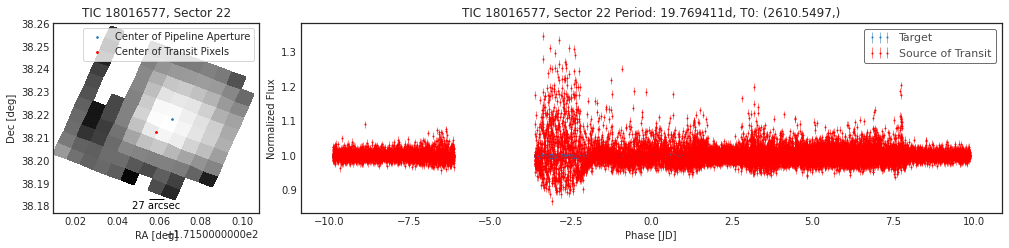

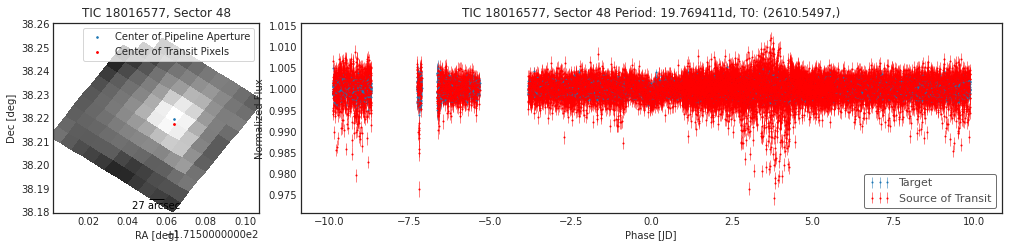

In [24]:
# Note: for TESS data, contaminate requires tpfs have been background corrected

result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True,
                                    sigma=4,  # default: 5
                                    spline_period=0.75,  # defualt: 1
#                                     cbvs=True,  # default: True
#                                     sff=False,  # always false for TESS
                                   );

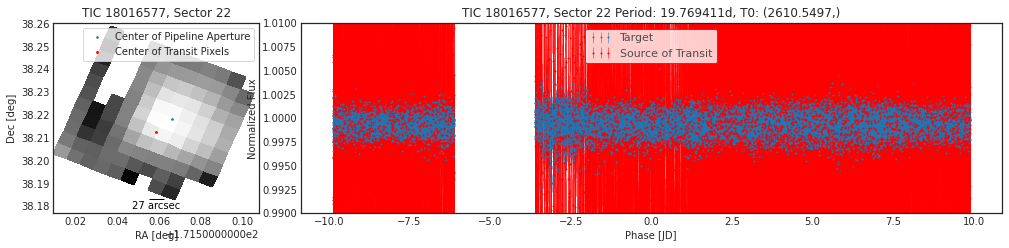

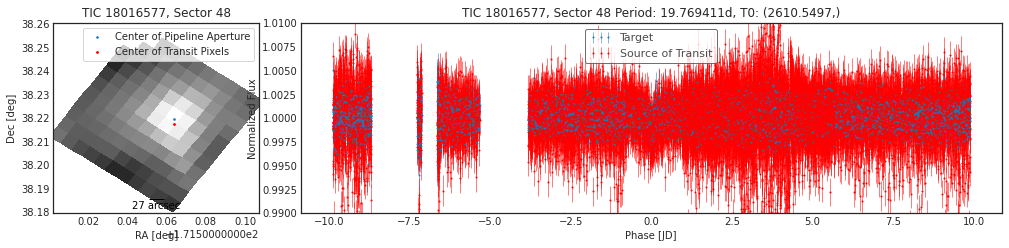

In [25]:
# To zoom in on lightcurve plot
result[0]["fig"].axes[1].set_ylim(0.99, 1.01)
display(result[0]["fig"])
result[-1]["fig"].axes[1].set_ylim(0.99, 1.01)
result[-1]["fig"]

In [26]:
for r in result:
    print("Sector", r["target_lc"].sector, " centroid shift:", r.get("centroid_shift"))

Sector 22  centroid shift: (<Quantity 34.13705801 arcsec>, <Quantity 6.24604326 arcsec>)
Sector 48  centroid shift: (<Quantity 7.72375194 arcsec>, <Quantity 193.71706435 arcsec>)


Aperture used by `contamiante`:

if a large aperture is chosen for contaminator, transit depth from `contaminate` would be shallower

For sector  48


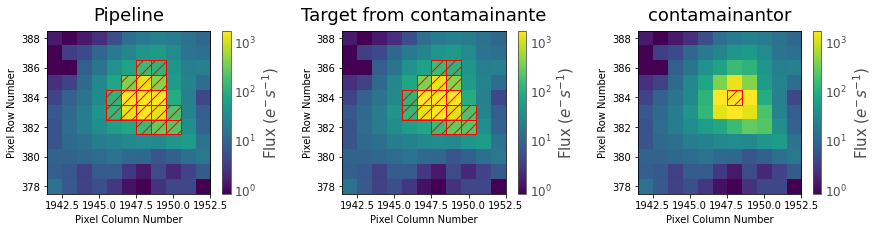

In [27]:
import matplotlib.pyplot as plt

idx = -1 # the sector to show
print("For sector ", result[idx]["target_lc"].sector, )

# fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# tpfs[idx].plot(aperture_mask=tpfs[idx].pipeline_mask, scale='log', ax=ax[0], title='Pipeline')
# tpfs[idx].plot(aperture_mask=result[idx]['contaminator_aper'], scale='log', ax=ax[1], title='contamainante');

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
tpfs[idx].plot(aperture_mask=tpfs[idx].pipeline_mask, scale='log', ax=ax[0], title='Pipeline')
tpfs[idx].plot(aperture_mask=result[idx]['target_aper'], scale='log', ax=ax[1], title='Target from contamainante')
if result[idx].get('contaminator_aper') is not None: 
    tpfs[idx].plot(aperture_mask=result[idx]['contaminator_aper'], scale='log', ax=ax[2], title='contamainantor');
else:
    print("No contaminator")

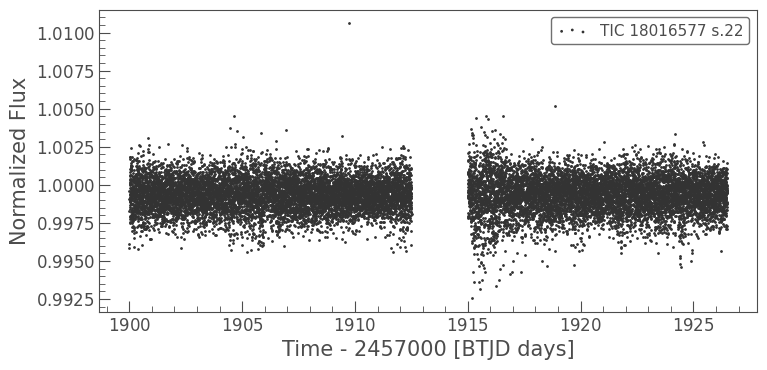

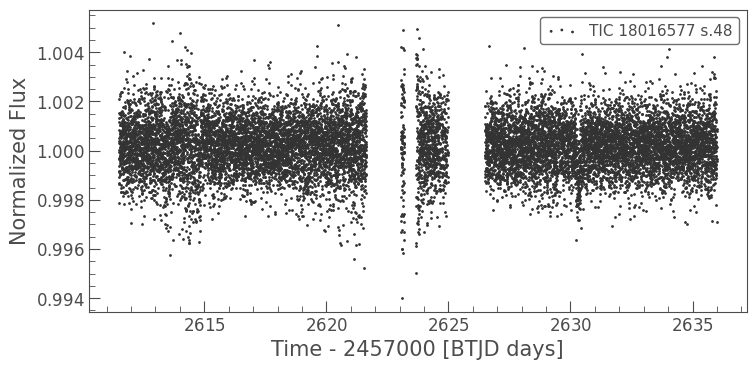

In [28]:
for r in result:
    lc = r.get("target_lc")
    if lc is not None:
        lc.scatter(label=f"{lc.label} s.{lc.sector}");
    else:
        print(f"No target lc")

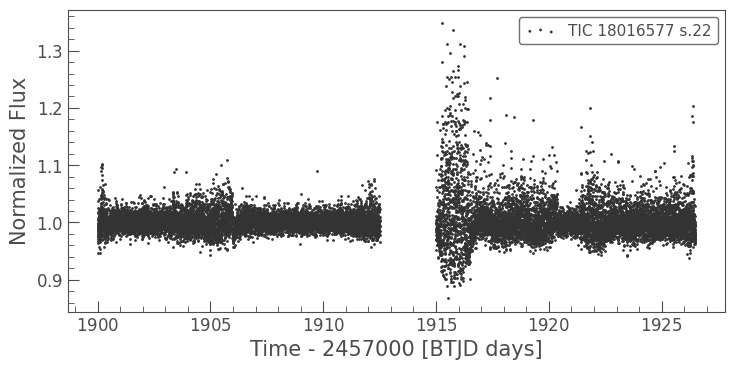

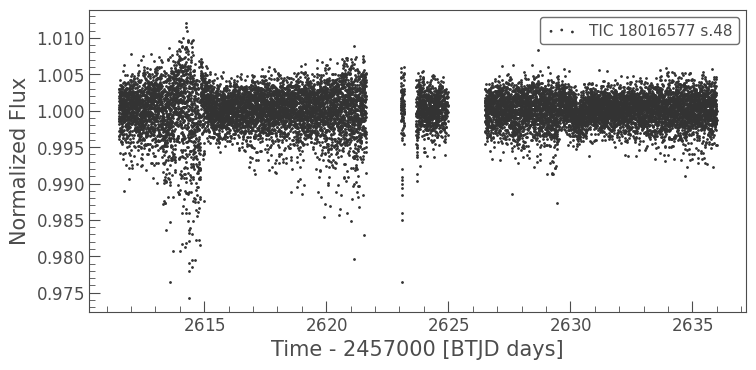

In [29]:
for r in result:
    lc = r.get("contaminator_lc")
    if lc is not None:
        lc.scatter(label=f"{lc.label} s.{lc.sector}");
    else:
        print(f"Sector {r['target_lc'].sector} has no contaminator lc")

Transit signficance at pixel level: to visualize where the dip comes from

For sector  48


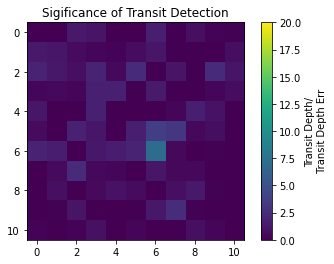

In [30]:
print("For sector ", result[idx]["target_lc"].sector, )

plt.imshow(result[idx]['transit_depth']/result[idx]['transit_depth_err'], vmin=0, vmax=20)
plt.title("Sigificance of Transit Detection")
cbar = plt.colorbar()
cbar.set_label("Transit Depth/\n Transit Depth Err")

In [31]:
from astropy import units as u 
from IPython.display import HTML

def show_tpf_orientation(tpf):
    """ "Helper to visualize the TPF's orientation in the sky. Requires IPython.
    Long arm is north, short arm with arrow is east.
    """
    coord_bottom_left = tpf.wcs.pixel_to_world(0, 0)
    coord_upper_right = tpf.wcs.pixel_to_world(tpf.shape[2] - 1, tpf.shape[1] - 1)
    coord_upper_left = tpf.wcs.pixel_to_world(0, tpf.shape[2] - 1)
    deg_from_north = coord_bottom_left.position_angle(coord_upper_left).to(u.deg).value

    display(
        HTML(
            f"""<div style="position: relative; margin-left: 16px;height: 64px;">
    <div title="Long arm: North; Short arm with arrow: East"
         style="float: left; max-width: 64px;font-size: 32px;margin: 16px;\
transform: rotate({-deg_from_north}deg);transform-origin: left; cursor:pointer;">↳</div>
        <div style="font-family: monospace;">Upper right offset from bottom left - <br>
        RA: {(coord_upper_right.ra - coord_bottom_left.ra).to(u.arcmin):0.6},
        Dec: {(coord_upper_right.dec - coord_bottom_left.dec).to(u.arcmin):0.6}
        </div>
    </div>"""
        )
    )

In [32]:
show_tpf_orientation(tpfs[idx])
tpfs[idx].interact_sky(notebook_url=notebook_url);

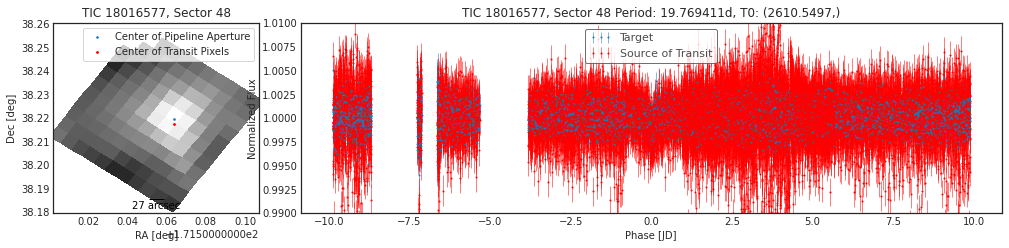

In [33]:
# to compare the with transit centroid from contaminate
result[idx]["fig"]

Using `contaminante` we can see two pieces of evidence that this target is contaminated.
1. There is a significant offset between the center of the **target** (blue dot) in the image, and the **source of the transiting signal** (red dot). **NOTE: The blue dot is the weighted average of the flux inside the pipeline aperture, for crowded sources this may not be accurate.**
2. There is a significant difference between the **target** phase curve (blue phase curve) and the **source of the transiting signal** phase curve (red phase curve).

We name the source of the transiting signal that `contaminante` finds the "contaminator".

The result is a list of dictionaries contains the depth and positions of the target and the "contamintor" for each quarter, including errors. The user is encouraged to 1) look at the phase curves 2) look at the positions of the contaminator and target and 3) the transit depths of the contaminator and the target before claiming that a target is contaminated. In the above cases there is a significant difference between the contaminator and the target.

## Usage notes

1. **Different quarters, campaigns and sectors.** If a target has multiple quarters, campaigns or sectors you can expect each dataset to have some slight offset, due to the target falling on different pixels.

2. **Shallower contaminator light curves.** `Contaminante` looks at each pixel individually to see if there is a significant transit signal. Because faint pixels can contribute a transiting signal at a lower, less significant level, some faint pixels can be missed in contaminante. In the case that the contaminator light curve is **shallower** than the target light curve, it is likely that some faint pixels have been missed from the optimum aperture. This does not indicate that there is any contamination.

